<a href="https://colab.research.google.com/github/myllanes/Introduction-to-Deep-Learning/blob/main/HW2_RESNET11_CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ResNet11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(12

100%|██████████| 169M/169M [02:13<00:00, 1.26MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Training loss: 3.76830206844796, Validation loss: 3.351119793261202, Validation Accuracy: 20.28%
Epoch 2, Training loss: 3.0911508465301356, Validation loss: 2.8633351158410214, Validation Accuracy: 28.16%
Epoch 3, Training loss: 2.644652207845003, Validation loss: 2.689115874683514, Validation Accuracy: 31.79%
Epoch 4, Training loss: 2.3000141334930295, Validation loss: 2.2348718292796956, Validation Accuracy: 40.71%
Epoch 5, Training loss: 2.019901459749433, Validation loss: 2.1410171597148664, Validation Accuracy: 43.12%
Epoch 6, Training loss: 1.786752340432092, Validation loss: 2.09384006737901, Validation Accuracy: 44.02%
Epoch 7, Training loss: 1.5677262667807264, Validation loss: 1.9113796275263777, Validation Accuracy: 48.27%
Epoch 8, Training loss: 1.3655749038481515, Validation loss: 1.8276132908872902, Validation Accuracy: 50.44%
Epoch 9, Training loss: 1.1624946034419865, Val

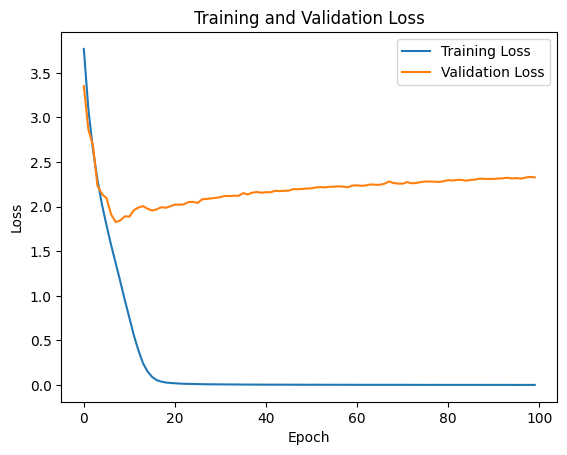

In [1]:
# Michael Yllanes

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        #self.dropout = nn.Dropout(0.3) #DROPOUT

        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet11(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet11, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)

        #out = self.dropout(out) #DROPOUT

        out = self.linear(out)
        return out

model = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes=100)
print(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

net = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(100):
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(trainloader))

    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()